# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# This project is my capstone project for Data Scientist Nanodegree in Udacity.
# In this project, I will use a machine learning model to predict whether or not someone will complete an offer based on demographics and offer portfolio.

In [1]:
import pandas as pd
import numpy as np
import math
import json
# % matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Explore and understand the dataset

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()
#     id (string) - offer id
#     offer_type (string) - type of offer ie BOGO, discount, informational
#     difficulty (int) - minimum required spend to complete an offer
#     reward (int) - reward given for completing an offer
#     duration (int) - time for offer to be open, in days
#     channels (list of strings)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
profile.head()
#     age (int) - age of the customer
#     became_member_on (int) - date when customer created an app account
#     gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
#     id (str) - customer id
#     income (float) - customer's income

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.head()
#     event (str) - record description (ie transaction, offer received, offer viewed, etc.)
#     person (str) - customer id
#     time (int) - time in hours since start of test. The data begins at time t=0
#     value - (dict of strings) - either an offer id or transaction amount depending on the record

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
# male_profile = profile.loc[profile['gender'] == "M"]
# male_profile.head()
# female_profile = profile.loc[profile['gender'] == "F"]
# female_profile.head()

# 2. Data Preprocessing

# 2.1. Pivot and merge dataset

In [10]:
def get_transaction_amount(row):
    if "transaction" in row["event"]:
        return row["value"].get('amount')
    return None

In [11]:
def get_offer_id(row):
    if "offer received" in row["event"] or "offer viewed" in row["event"]:
        return row["value"].get('offer id')
    elif "offer completed" in row["event"]:
        return row["value"].get('offer_id')
    elif "transaction" in row["event"]:
        return None
    return None
    

In [12]:
transcript['trans_amount'] = transcript.apply(lambda row: get_transaction_amount(row), axis=1)

In [13]:
transcript['offer_id'] = transcript.apply(lambda row: get_offer_id(row), axis=1)

In [14]:
transcript.head()

,event,person,time,value,trans_amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
transaction_amount = transcript.groupby('person')['trans_amount'].sum()
transaction_amount = transaction_amount.reset_index()

In [16]:
transaction_amount.head()

,person,trans_amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [17]:
transcript['tmp'] = 1

In [18]:
pivot_transcript = pd.pivot_table(transcript, index=['person', 'offer_id'], columns='event', values='tmp').fillna(0)
pivot_transcript = pivot_transcript.reset_index()

In [19]:
pivot_transcript.head()

event,person,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0


In [20]:
# A user can receive an offer, never actually view the offer, but still spend to complete the offer 
# so an offer succeed only when the customer completes 3 steps of the offer
# full_completed: 1
# not_completed: 0
def get_full_completed(row):
    if row['offer completed']==1 and row['offer received']==1 and row['offer viewed']==1:
        return 1
    return 0

In [21]:
pivot_transcript['full_completed'] = pivot_transcript.apply(lambda row: get_full_completed(row), axis=1)
pivot_transcript.head()

event,person,offer_id,offer completed,offer received,offer viewed,full_completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1


In [22]:
# table.loc[table['offer completed'] == 0]

In [23]:
pivot_transcript = pivot_transcript.merge(transaction_amount, how='outer', left_on='person', right_on='person')

In [24]:
# Merge transcript and profile based on customer id
transcript_profile = pivot_transcript.merge(profile, how='outer', left_on='person', right_on='id').drop(columns=['id'])

In [25]:
# Merge transcript_profile and portfolio based on offer id
transcript_profile_portfolio = transcript_profile.merge(portfolio, how='outer', left_on='offer_id', right_on='id').drop(columns=['id'])

In [26]:
transcript_profile_portfolio.rename(columns = {'offer completed':'offer_completed', 'offer received':'offer_received', 'offer viewed':'offer_viewed'}, inplace = True)

In [27]:
transcript_profile_portfolio.head()

,person,offer_id,offer_completed,offer_received,offer_viewed,full_completed,trans_amount,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,0.0,127.60,33,20170421,M,72000.0,"[web, email, mobile]",10.0,7.0,discount,2.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0.0,1.0,0.0,0.0,68.51,19,20160809,F,65000.0,"[web, email, mobile]",10.0,7.0,discount,2.0
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0.0,1.0,0.0,0.0,20.36,56,20171209,M,47000.0,"[web, email, mobile]",10.0,7.0,discount,2.0
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,1.0,1.0,33.50,118,20160503,None,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,1.0,1.0,375.12,58,20171207,F,119000.0,"[web, email, mobile]",10.0,7.0,discount,2.0


# 2.2 Dealing with null values

In [28]:
# Check nulls
transcript_profile_portfolio.isnull().sum()

person                 0
offer_id               6
offer_completed        6
offer_received         6
offer_viewed           6
full_completed         6
trans_amount           0
age                    0
became_member_on       0
gender              8067
income              8067
channels               6
difficulty             6
duration               6
offer_type             6
reward                 6
dtype: int64

In [29]:
merged_df = transcript_profile_portfolio

In [30]:
# Dealing with null values of income
merged_df['income']=merged_df['income'].fillna(merged_df['income'].mean())

In [31]:
# Dealing with other null values
merged_df = merged_df.dropna(how='any',axis=0)

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 16 columns):
person              55222 non-null object
offer_id            55222 non-null object
offer_completed     55222 non-null float64
offer_received      55222 non-null float64
offer_viewed        55222 non-null float64
full_completed      55222 non-null float64
trans_amount        55222 non-null float64
age                 55222 non-null int64
became_member_on    55222 non-null int64
gender              55222 non-null object
income              55222 non-null float64
channels            55222 non-null object
difficulty          55222 non-null float64
duration            55222 non-null float64
offer_type          55222 non-null object
reward              55222 non-null float64
dtypes: float64(9), int64(2), object(5)
memory usage: 7.2+ MB


In [33]:
# There's no null value now
merged_df.isnull().sum()

person              0
offer_id            0
offer_completed     0
offer_received      0
offer_viewed        0
full_completed      0
trans_amount        0
age                 0
became_member_on    0
gender              0
income              0
channels            0
difficulty          0
duration            0
offer_type          0
reward              0
dtype: int64

# 3. Exploratory Analysis and Visualization

# 3.1. Age distribution of the customers

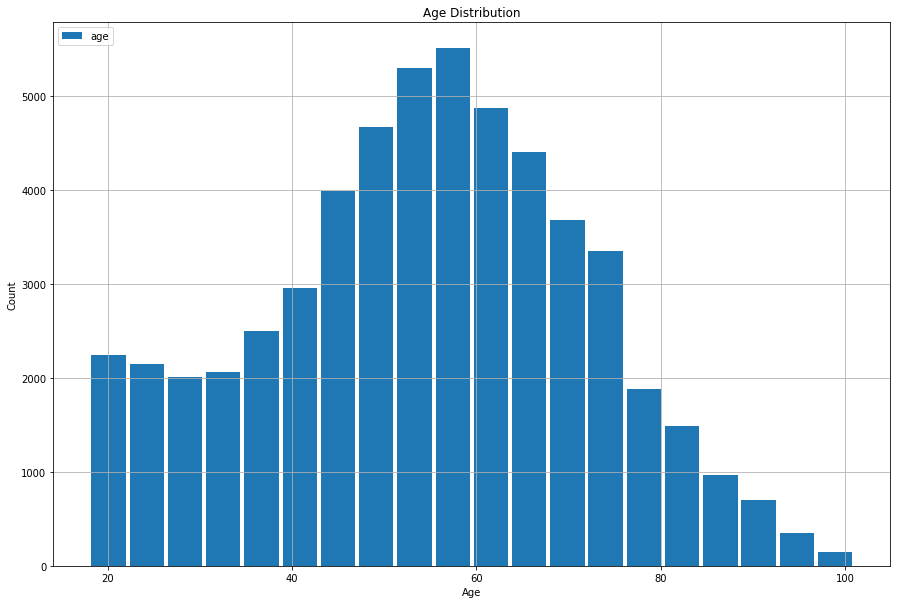

In [34]:
merged_df["age"].plot.hist(figsize=(15,10),grid=True, bins=20,rwidth=0.9, lw=3)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc = "upper left")
plt.show()

# 3.2. Income distribution of the customers

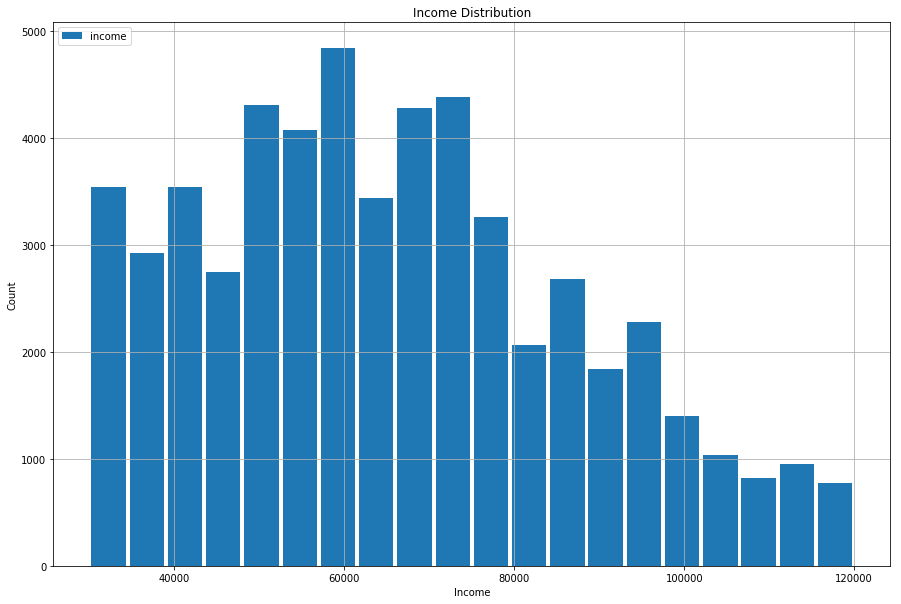

In [35]:
merged_df["income"].plot.hist(figsize=(15,10),grid=True, bins=20, rwidth=0.9, lw=3)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend(loc = "upper left")
plt.show()

# 3.3. Percentage of customers who got successful offers

Text(0.5,1,'Percentage of customers who got successful offers')

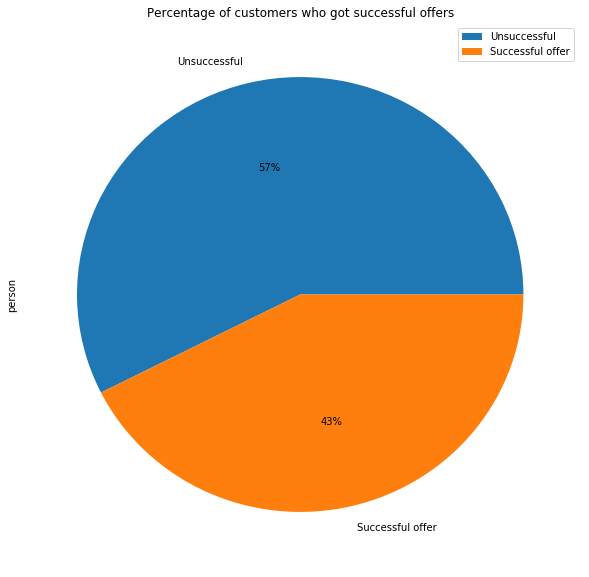

In [36]:
merged_df.groupby(['full_completed']).count().plot(figsize=(10,10), kind='pie', y='person', autopct='%1.0f%%', labels = ["Unsuccessful", "Successful offer"])
plt.title('Percentage of customers who got successful offers')

# 4. Predictive Modeling

In [37]:
features = merged_df.drop(columns=['offer_id', 'person', 'offer_completed','offer_received', 'offer_viewed', 'trans_amount'])

In [38]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 10 columns):
full_completed      55222 non-null float64
age                 55222 non-null int64
became_member_on    55222 non-null int64
gender              55222 non-null object
income              55222 non-null float64
channels            55222 non-null object
difficulty          55222 non-null float64
duration            55222 non-null float64
offer_type          55222 non-null object
reward              55222 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.6+ MB


In [39]:
# Convert all values to integer
# Channels
features['channels_str'] = [','.join(map(str, l)) for l in features['channels']]
channels = features["channels_str"].unique()
channels = {channels[i] : i for i in range(len(channels))}

In [40]:
# Genders
genders = features["gender"].unique()
genders = {genders[i] : i for i in range(len(genders))}

In [41]:
# Offer types
offer_types = features["offer_type"].unique()
offer_types = {offer_types[i] : i for i in range(len(offer_types))}

In [42]:
x = features.drop(columns=['full_completed', 'channels'])
y = features['full_completed']

In [43]:
x['gender'] = x['gender'].replace(genders)
x['channels_str'] = x['channels_str'].replace(channels)
x['offer_type'] = x['offer_type'].replace(offer_types)
x.head()

,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,channels_str
0,33,20170421,0,72000.0,10.0,7.0,0,2.0,0
1,19,20160809,1,65000.0,10.0,7.0,0,2.0,0
2,56,20171209,0,47000.0,10.0,7.0,0,2.0,0
4,58,20171207,1,119000.0,10.0,7.0,0,2.0,0
5,26,20141221,0,61000.0,10.0,7.0,0,2.0,0


In [44]:
feature_names = x.columns
labels = y.unique

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 4.1. Decision Tree Classifier

In [50]:
list_score = []
n = 13
for i in range(1,n):
    dtree = DecisionTreeClassifier(max_depth=i, random_state=5)
    dtree.fit(x_train,y_train)
    y_pred = dtree.predict(x_test)
    list_score.append(round(accuracy_score(y_test,y_pred),4))
print(f"Max_depth: {list_score.index(max(list_score))}")
print(f"Max Accuracy Score: {max(list_score)}")

Max_depth: 7
Max Accuracy Score: 0.7603


In [51]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

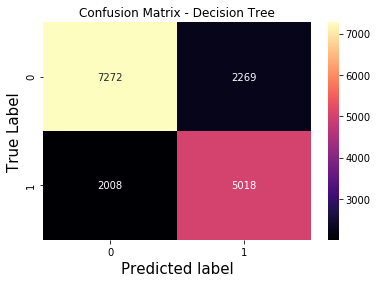

In [52]:
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
plt.figure(figsize=(10,10))
sns.heatmap(matrix_df, annot= True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
plt.show()

In [53]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.78      0.76      0.77      9541
        1.0       0.69      0.71      0.70      7026

avg / total       0.74      0.74      0.74     16567



# 4.2. K-nearest neighbors Classifier

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# accuracy score of the model
accuracy_score = model.score(x_test, y_test)

In [56]:
print(f"Accuracy score: {accuracy_score}")

Accuracy score: 0.6217178728798213


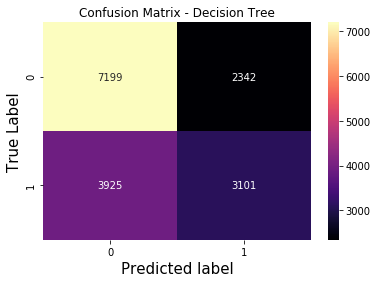

In [57]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
plt.figure(figsize=(10,10))
sns.heatmap(matrix_df, annot= True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
plt.show()

In [58]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.65      0.75      0.70      9541
        1.0       0.57      0.44      0.50      7026

avg / total       0.61      0.62      0.61     16567



# 5. Conclusion

I just tried to build 2 models KNN and DecisionTree to predict whether or not a customer will fully complete an offer. The accuracy score of DecisionTree is nearly 76%, better than KNN, just about 62%. However, to improve the result, I think I can try more models and there are still many ways to explore this dataset, which may give me more interesting information.

I still confused about how to choose the right model, and what makes a model generate a better results than the others on a dataset. I will continue to investigate and learn.
